<a href="https://colab.research.google.com/github/dotimothy/Classifiers/blob/main/MNIST/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Dataset Notebook
This notebook explores the [MNIST](https://www.cs.toronto.edu/~kriz/cifar.html) dataset [1] and how to use it in Python with different classification architectures learned in C147/247 at UCLA. As a summary, the MNIST dataset is a dataset comprising of handwritten digits with 60,000 samples and 10 classes (i.e. labels from 0-9).

## Citations
[1] L. Deng, ‘The MNIST Database of Handwritten Digit Images for Machine Learning Research [Best of the Web]’, IEEE Signal Processing Magazine, vol. 29, no. 6, pp. 141–142, 2012.

## Dependencies

In [1]:
# Checking if Environment is Google CoLab
IN_COLAB = True
try: 
    import google.colab
except:
    IN_COLAB = False
print(f'In CoLab: {IN_COLAB}')
if(IN_COLAB):
    !curl https://raw.githubusercontent.com/dotimothy/Classifiers/main/requirements.txt -o ./requirements.txt

In CoLab: False


In [2]:
if(IN_COLAB):
    !pip install -r ./requirements.txt
else:
    !pip install -r ../requirements.txt

In [3]:
# Libraries
import gzip
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

class bold:
   START = '\033[1m'
   END = '\033[0m'

## Loading Data and Visualizing It

In [4]:
# Downloading the Data 
dataDir = '../data/MNIST'
os.makedirs(dataDir,exist_ok=True)
tars = ['train-images-idx3-ubyte.gz','train-labels-idx1-ubyte.gz','t10k-images-idx3-ubyte.gz','t10k-labels-idx1-ubyte.gz']
for tar in tars:
    tarPath = f'{dataDir}/{tar}'
    if(not(os.path.exists(tarPath))): # Downloading Tar
        tarLink = f'https://raw.githubusercontent.com/fgnt/mnist/master/{tar}'
        os.system(f'curl {tarLink} -o {tarPath}')

In [5]:
# Extracting the Data 
def read_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        # Read the magic number (4 bytes)
        f.read(4)
        
        # Read the number of images, rows, and columns
        num_images = int.from_bytes(f.read(4), 'big')
        num_rows = int.from_bytes(f.read(4), 'big')
        num_cols = int.from_bytes(f.read(4), 'big')
        
        # Read the image data (each image is num_rows * num_cols bytes)
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, num_rows, num_cols)
        
    return images

def read_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        # Read the magic number (4 bytes)
        f.read(4)
        
        # Read the number of labels
        num_labels = int.from_bytes(f.read(4), 'big')
        
        # Read the label data (one byte per label)
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        
    return labels

# Extracting Dataset
X_train_val = read_mnist_images(f'{dataDir}/train-images-idx3-ubyte.gz')
Y_train_val = read_mnist_labels(f'{dataDir}/train-labels-idx1-ubyte.gz')
X_test = read_mnist_images(f'{dataDir}/t10k-images-idx3-ubyte.gz')
Y_test = read_mnist_labels(f'{dataDir}/t10k-labels-idx1-ubyte.gz')

# Standard Logistics
print("Training/Validation Data Shape:",X_train_val.shape)
print("Training/Validation Labels Shape:",Y_train_val.shape)
print("Testing Data Shape:",X_test.shape)
print("Testing Label Shape:",Y_test.shape)

Training/Validation Data Shape: (60000, 28, 28)
Training/Validation Labels Shape: (60000,)
Testing Data Shape: (10000, 28, 28)
Testing Label Shape: (10000,)


In [6]:
# Splitting Train/Val Tensors
def splitTrainVal(X_train_val,Y_train_val,num_train=50000):
    num_val = X_train_val.shape[0]-num_train
    train_mask = list(range(num_train))
    val_mask = list(range(num_train,num_train+num_val))
    return X_train_val[train_mask], Y_train_val[train_mask], X_train_val[val_mask], Y_train_val[val_mask]

# Train/Val Logistics
X_train, Y_train, X_val, Y_val = splitTrainVal(X_train_val,Y_train_val)
print("Training Data Shape:",X_train.shape)
print("Training Labels Shape:",Y_train.shape)
print("Validation Data Shape:",X_val.shape)
print("Validation Labels Shape:",Y_val.shape)

Training Data Shape: (50000, 28, 28)
Training Labels Shape: (50000,)
Validation Data Shape: (10000, 28, 28)
Validation Labels Shape: (10000,)


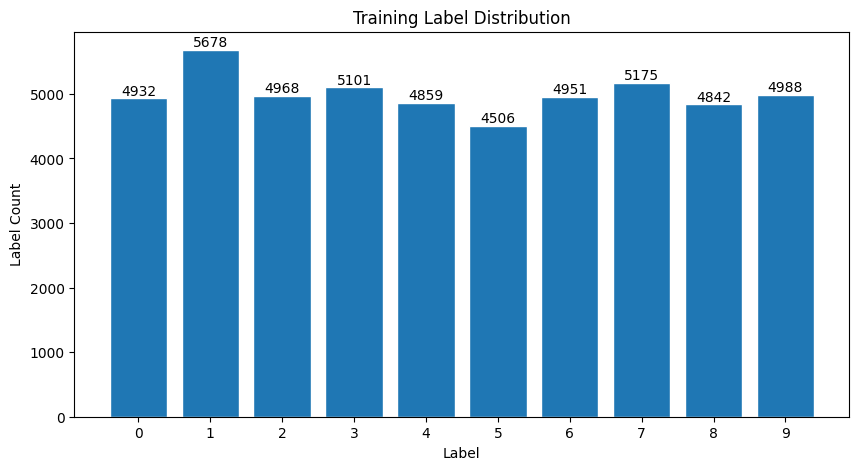

In [7]:
classes = list(range(10))
# Label Distributions for Training Data
plt.figure(figsize=(10,5))
counts, bins = np.histogram(Y_train)
trainTitle = plt.title('Training Label Distribution')
trainXLabel = plt.xlabel('Label')
plt.xticks(classes)
trainYLabel = plt.ylabel('Label Count')
trainBar = plt.bar(classes,counts,align='center',edgecolor='white')
for i,count in enumerate(counts): # Adding Bar Labels
  plt.text(i, 1.01*count, count, ha = 'center')

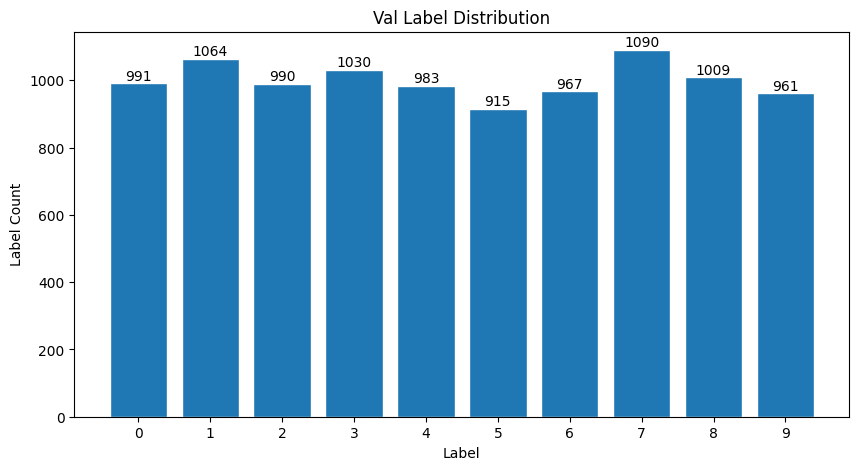

In [8]:
# Label Distributions for Validation Data
plt.figure(figsize=(10,5))
counts, bins = np.histogram(Y_val)
trainTitle = plt.title('Val Label Distribution')
trainXLabel = plt.xlabel('Label')
plt.xticks(classes)
trainYLabel = plt.ylabel('Label Count')
trainBar = plt.bar(classes,counts,align='center',edgecolor='white')
for i,count in enumerate(counts): # Adding Bar Labels
  plt.text(i, 1.01*count, count, ha = 'center')

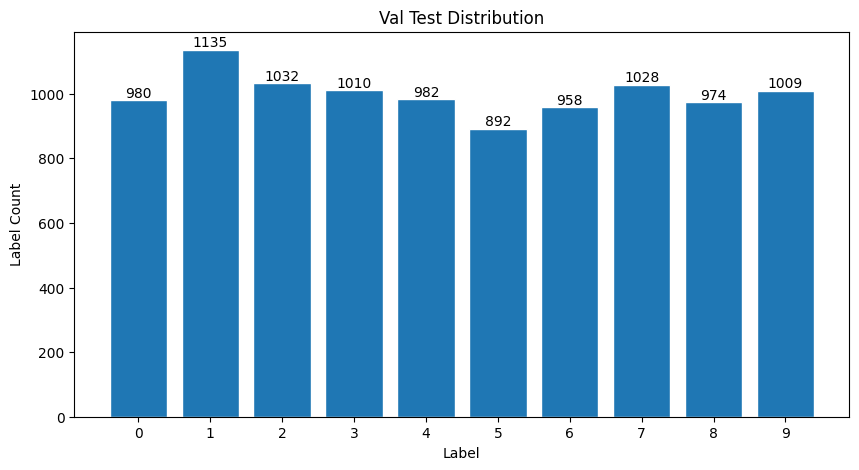

In [9]:
# Label Distributions for Test Data
plt.figure(figsize=(10,5))
counts, bins = np.histogram(Y_test)
trainTitle = plt.title('Val Test Distribution')
trainXLabel = plt.xlabel('Label')
plt.xticks(classes)
trainYLabel = plt.ylabel('Label Count')
trainBar = plt.bar(classes,counts,align='center',edgecolor='white')
for i,count in enumerate(counts): # Adding Bar Labels
  plt.text(i, 1.01*count, count, ha = 'center')

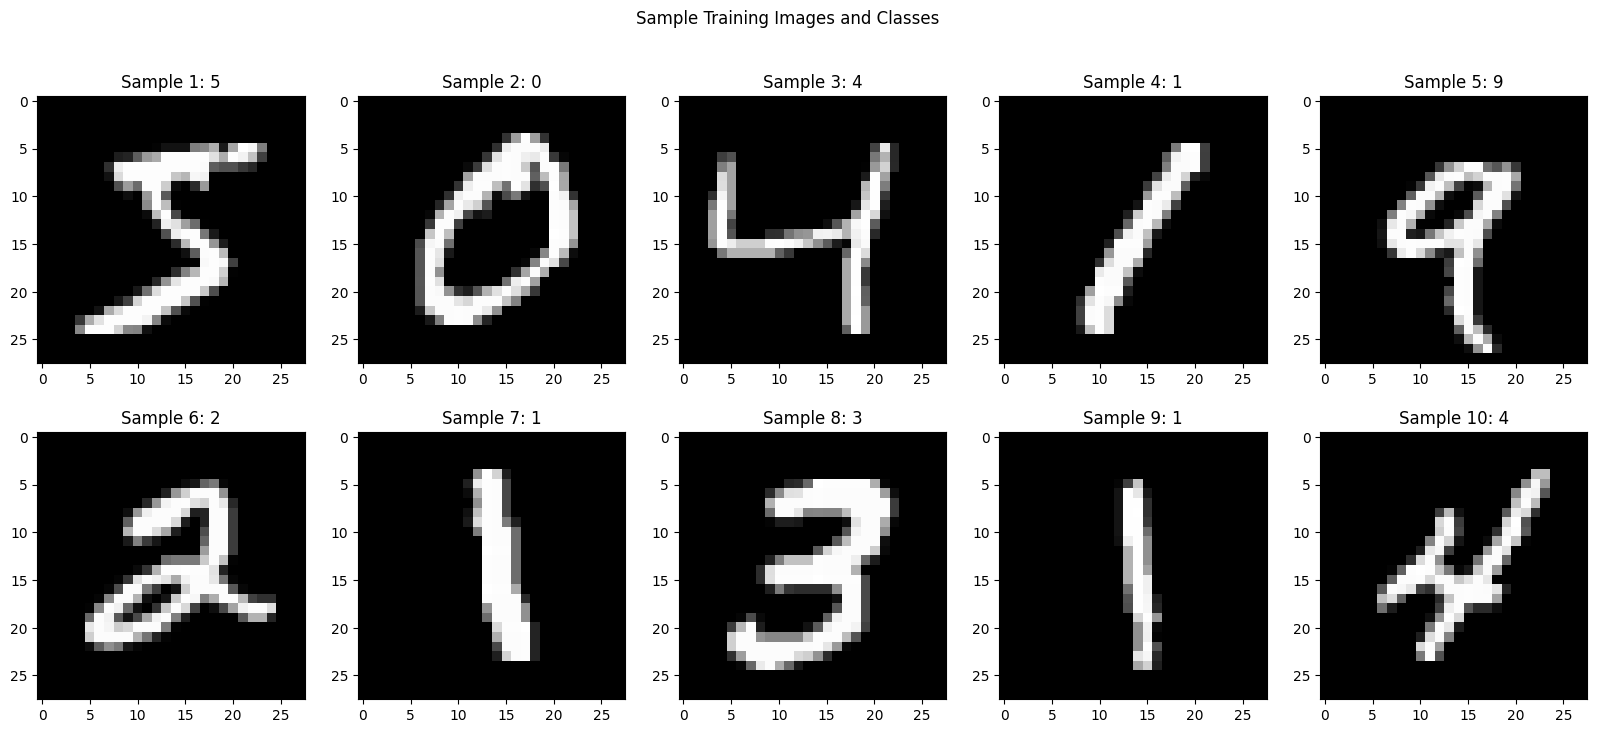

In [10]:
# Visualizing Training Set
rows = 2
cols = 5
fig, ax = plt.subplots(rows,cols,figsize=(4*cols,4*rows))
sampleTitle = fig.suptitle("Sample Training Images and Classes")
for i in range(ax.shape[0]):
  for j in range(ax.shape[1]):
    ax[i][j].imshow(X_train[i*cols+j].astype('uint8'),cmap='gray')
    ax[i][j].set_title(f'Sample {i*cols+j+1}: {classes[Y_train[i*cols+j]]}')

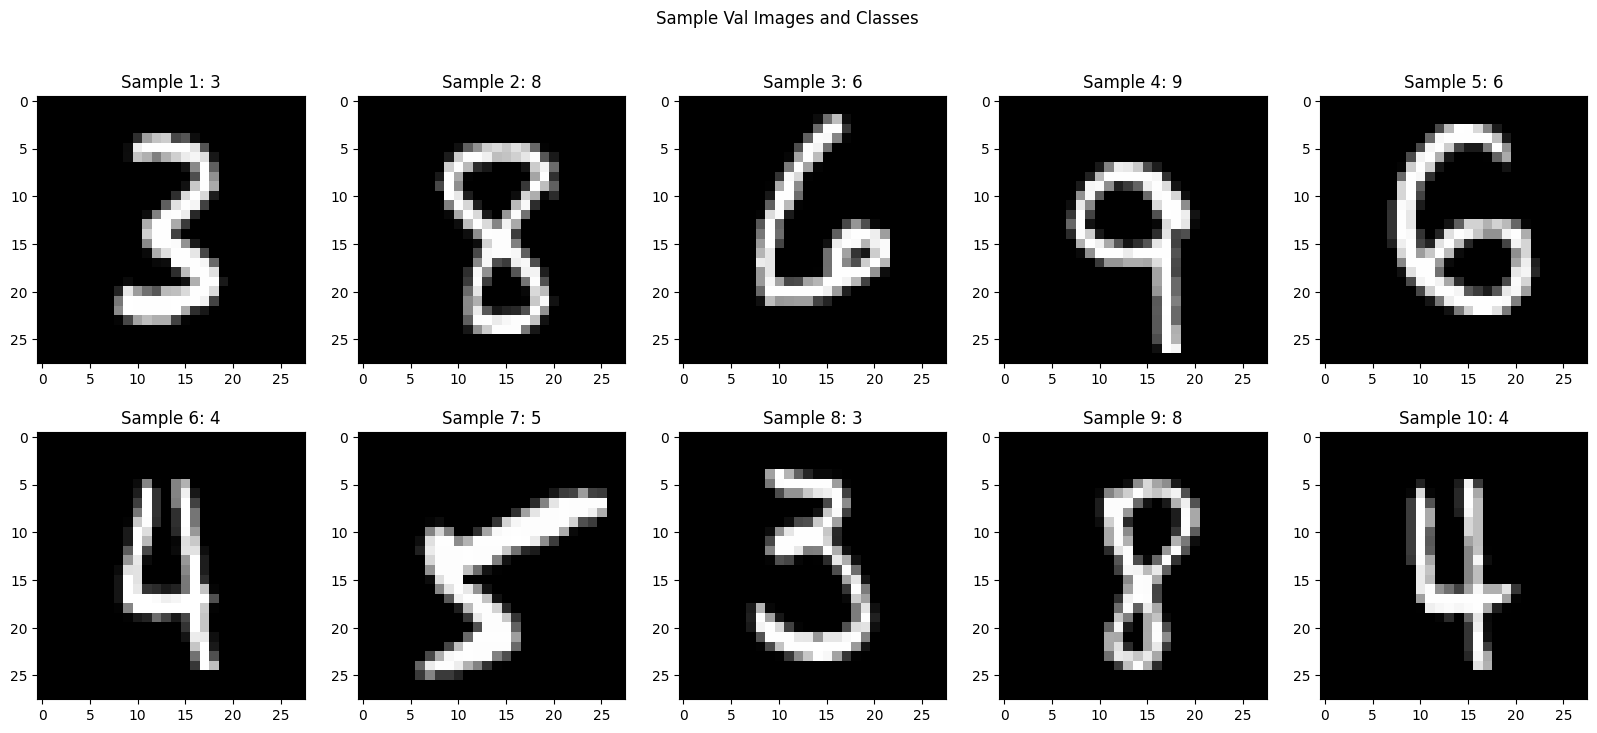

In [11]:
# Visualizing Validation Set
rows = 2
cols = 5
fig, ax = plt.subplots(rows,cols,figsize=(4*cols,4*rows))
sampleTitle = fig.suptitle("Sample Val Images and Classes")
for i in range(ax.shape[0]):
  for j in range(ax.shape[1]):
    ax[i][j].imshow(X_val[i*cols+j].astype('uint8'),cmap='gray')
    ax[i][j].set_title(f'Sample {i*cols+j+1}: {classes[Y_val[i*cols+j]]}')

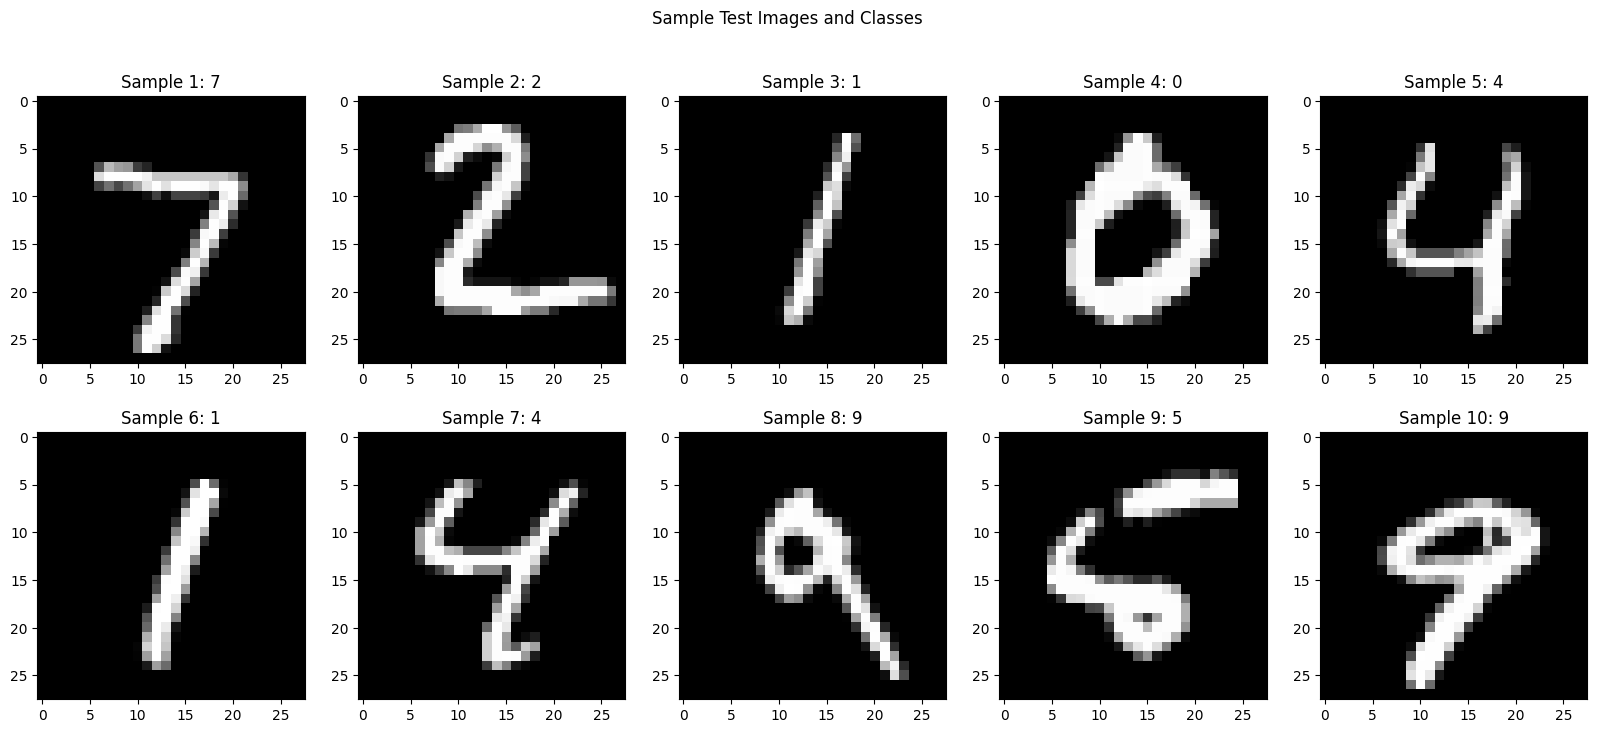

In [12]:
# Visualizing Test Set
rows = 2
cols = 5
fig, ax = plt.subplots(rows,cols,figsize=(4*cols,4*rows))
sampleTitle = fig.suptitle("Sample Test Images and Classes")
for i in range(ax.shape[0]):
  for j in range(ax.shape[1]):
    ax[i][j].imshow(X_test[i*cols+j].astype('uint8'),cmap='gray')
    ax[i][j].set_title(f'Sample {i*cols+j+1}: {classes[Y_test[i*cols+j]]}')

## Neural Network Architectures

### Device Configuration

In [13]:
# Setup PyTorch Device (Assuming only Single Device)
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device = torch.device(device)
gpuName = f'({torch.cuda.get_device_name(device)})' if torch.cuda.is_available() else ''
print(f'Using PyTorch Backend: {device} {gpuName}')

Using PyTorch Backend: mps 


### Helper Functions

In [14]:
# Training/Validating/Testing a Classifier Model
def train(model,optimizer,criterion,train_loader,val_loader,test_loader,num_epochs=50,verbose=False):
    # Defining Initial Variables
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    test_acc = 0

    # Training Loop
    print(f'Training Model {model.__class__.__name__}')
    print('Training and Validation')
    for epoch_idx in (range(num_epochs) if verbose else tqdm(range(num_epochs))):
        # Training
        model.train()
        train_count = 0
        train_correct_count = 0
        train_loss = 0
        for batch_idx, (train_x, train_y) in enumerate(train_loader):
            train_x = train_x.float().to(device)
            train_y = train_y.long().to(device)
            optimizer.zero_grad() # 
            logits = model(train_x)
            loss = criterion(logits, train_y)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                train_loss += loss.cpu().numpy()
                y_hat = torch.argmax(logits, dim=-1)
                train_correct_count += torch.sum(y_hat == train_y, axis=-1)
                train_count += train_x.size(0)
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_acc = train_correct_count / train_count
        train_accs.append(train_acc.cpu().numpy())

        # Validation
        model.eval()
        val_count = 0
        val_correct_count = 0
        val_loss = 0
        with torch.no_grad():
            for idx, (val_x, val_y) in enumerate(val_loader):
                val_x = val_x.float().to(device)
                val_y = val_y.long().to(device)
                logits = model(val_x).detach()
                val_loss += criterion(logits,val_y).cpu().numpy()
                y_hat = torch.argmax(logits, dim=-1)
                val_correct_count += torch.sum(y_hat == val_y, axis=-1)
                val_count += val_x.size(0)
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_acc = val_correct_count / val_count
        val_accs.append(val_acc.cpu().numpy())
        
        if(verbose): print(f'Epoch #{epoch_idx+1}/{num_epochs}. Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}')

    print(f'Final Train Acc: {train_acc:.3f}, Final Val Acc: {val_acc:.3f}')

    # Test
    test_acc = test(model,optimizer,test_loader,verbose=True)

    return {'model': model, 'num_epochs': num_epochs, 'train_losses':train_losses, 'val_losses':val_losses, 'train_accs':train_accs, 'val_accs': val_accs, 'test_acc': test_acc}

# Testing Out Model
def test(model,optimizer,test_loader,verbose=False):
    # Test
    if(verbose): print('\nTesting')
    model.eval()
    with torch.no_grad():
        test_count = 0
        test_correct_count = 0
        for idx, (test_x, test_y) in enumerate(test_loader):
            test_x = test_x.float().to(device)
            test_y = test_y.long().to(device)
            logits = model(test_x).detach()
            y_hat = torch.argmax(logits, dim=-1)
            test_correct_count += torch.sum(y_hat == test_y, axis=-1)
            test_count += test_x.size(0)
        test_acc = (test_correct_count / test_count).cpu().numpy()
        if(verbose): print(f'Test Acc: {test_acc:.3f}')
    return test_acc

# Plotting Results
def plot_results(result):
    fig,ax = plt.subplots(1,2,figsize=(12,6))
    fig.suptitle(result['model'].__class__.__name__)
    ax[0].set_title(f"Losses")
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].plot(result['train_losses'])
    ax[0].plot(result['val_losses'])
    ax[0].legend(['Train','Val'])
    ax[0].grid(True)
    ax[1].set_title(f"Accuracies")
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].plot(result['train_accs'])
    ax[1].plot(result['val_accs'])
    ax[1].plot(result['num_epochs'],result['test_acc'],'ro')
    ax[1].legend(['Train','Val','Test'])
    ax[1].grid(True)
    plt.tight_layout()
    plt.show()

# Saving Results
def save_results(result,device,verbose=False):
    baseName = f"{result['model'].__class__.__name__}MNIST"
    # Saving PyTorch Model
    result['model'].eval()
    torch.save(result['model'],f'{baseName}.pt')
    if(verbose): print(f'{baseName} PyTorch model Saved to {baseName}.pt')
    dummy = torch.randn((1,28,28)).to(device)
    torch.onnx.export(result['model'],dummy,f'{baseName}.onnx',verbose=verbose)
    if(verbose): print(f'{baseName} Onnx Model Saved to {baseName}.onnx')

SyntaxError: f-string: unmatched '[' (1756061736.py, line 108)

### 1. FCNet

In [22]:
class FCNet(nn.Module):
    """ A Fully Connected Net with Batch Norm and Dropout """
    def __init__(self,input_dim=784,hidden_dim=250,hidden_layers=1,num_classes=10,p=0):
        super(FCNet,self).__init__()

        layers = []

        # Input Layer
        input_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim,hidden_dim),
            nn.BatchNorm1d(num_features=hidden_dim),
            nn.ReLU(),
            nn.Dropout1d(p=p),
        )
        layers.append(input_layer)

        # Hidden Layer
        hidden_layer = nn.Sequential(
            nn.Linear(hidden_dim,hidden_dim),
            nn.BatchNorm1d(num_features=hidden_dim),
            nn.ReLU(),
            nn.Dropout1d(p=p),
        )
        for h in range(hidden_layers):
            layers.append(hidden_layer) 

        # Output Layer
        output_layer = nn.Sequential(
            nn.Linear(hidden_dim,num_classes),
            nn.Softmax(dim=1),
        )
        layers.append(output_layer)

        self.model = nn.ModuleList(layers)

    def forward(self,x):
        for layer in self.model:
            x = layer(x)
        return x

print(FCNet())

FCNet(
  (model): ModuleList(
    (0): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=250, bias=True)
      (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Dropout1d(p=0, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=250, out_features=250, bias=True)
      (1): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout1d(p=0, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=250, out_features=10, bias=True)
      (1): Softmax(dim=1)
    )
  )
)


In [23]:
# Define Model Parameters
model = FCNet().to(device)
cel_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Creating Data Tensors & Datasets
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.long)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)
train_data = torch.utils.data.TensorDataset(X_train_tensor,Y_train_tensor)
valid_data = torch.utils.data.TensorDataset(X_val_tensor,Y_val_tensor)
test_data = torch.utils.data.TensorDataset(X_test_tensor,Y_test_tensor)

# Creating Data Loaders
batch_size = 2500
train_loader = torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(valid_data,shuffle=False,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data,shuffle=False,batch_size=batch_size)

In [24]:
# Training the FCNet
result = train(model,optimizer,cel_loss,train_loader,val_loader,test_loader,verbose=False)

Training Model FCNet
Training and Validation


100%|██████████| 50/50 [00:15<00:00,  3.17it/s]

Final Train Acc: 0.998, Final Val Acc: 0.980

Testing
Test Acc: 0.981


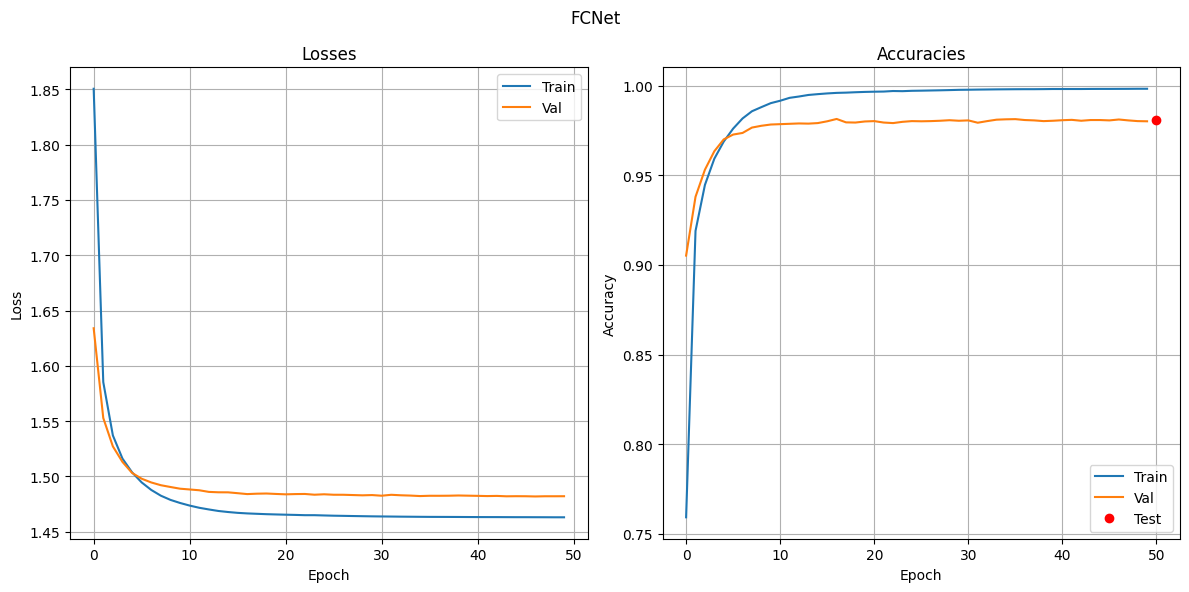

In [26]:
# Plotting FCNet Results
plot_results(result)

In [28]:
# Saving the FCNet Model
save_results(result,device,verbose=True)

FCNet PyTorch model Saved to FCNet.pt
Exported graph: graph(%onnx::Flatten_0 : Float(1, 28, 28, strides=[784, 28, 1], requires_grad=0, device=mps:0),
      %model.0.1.weight : Float(250, 784, strides=[784, 1], requires_grad=1, device=mps:0),
      %model.0.1.bias : Float(250, strides=[1], requires_grad=1, device=mps:0),
      %model.0.2.weight : Float(250, strides=[1], requires_grad=1, device=mps:0),
      %model.0.2.bias : Float(250, strides=[1], requires_grad=1, device=mps:0),
      %model.0.2.running_mean : Float(250, strides=[1], requires_grad=0, device=mps:0),
      %model.0.2.running_var : Float(250, strides=[1], requires_grad=0, device=mps:0),
      %model.1.0.weight : Float(250, 250, strides=[250, 1], requires_grad=1, device=mps:0),
      %model.1.0.bias : Float(250, strides=[1], requires_grad=1, device=mps:0),
      %model.1.1.weight : Float(250, strides=[1], requires_grad=1, device=mps:0),
      %model.1.1.bias : Float(250, strides=[1], requires_grad=1, device=mps:0),
      %

### 2. ConvNet

In [29]:
# Define the CNN model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        # First Conv1d layer: input (1 channel), output (16 channels), kernel size 5
        self.conv1 = nn.Conv1d(28, 64, kernel_size=3, stride=1, padding=1)  # input (28 rows, 1 channel)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        
        # Max pooling layer to reduce sequence length
        self.pool = nn.MaxPool1d(2)
        
        # Fully connected layer
        self.fc1 = nn.Linear(128 * 7, 128)  # Flattened output from Conv1d
        self.fc2 = nn.Linear(128, 10)       # Output layer (10 classes for digits 0-9)

    def forward(self, x):
        # Apply Conv1d + ReLU activation
        x = F.relu(self.conv1(x))  # Apply 1D convolution + ReLU
        x = self.pool(x)  # Apply max pooling
        
        x = F.relu(self.conv2(x))  # Apply second 1D convolution + ReLU
        x = self.pool(x)  # Apply max pooling
        
        # Flatten the output from Conv1d layers to feed into the fully connected layer
        x = x.view(-1, 128 * 7)  # Flatten: (batch_size, 128 * 7)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Final output layer
        
        return x

print(ConvNet())

ConvNet(
  (conv1): Conv1d(28, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=896, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [30]:
# Define Model Parameters
model = ConvNet().to(device)
cel_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Creating Data Tensors & Datasets
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.long)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)
train_data = torch.utils.data.TensorDataset(X_train_tensor,Y_train_tensor)
valid_data = torch.utils.data.TensorDataset(X_val_tensor,Y_val_tensor)
test_data = torch.utils.data.TensorDataset(X_test_tensor,Y_test_tensor)

# Creating Data Loaders
batch_size = 2500
train_loader = torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(valid_data,shuffle=False,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data,shuffle=False,batch_size=batch_size)

In [31]:
# Training the ConvNet
result = train(model,optimizer,cel_loss,train_loader,val_loader,test_loader,verbose=False)

Training Model ConvNet
Training and Validation


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]

Final Train Acc: 1.000, Final Val Acc: 0.979

Testing
Test Acc: 0.980


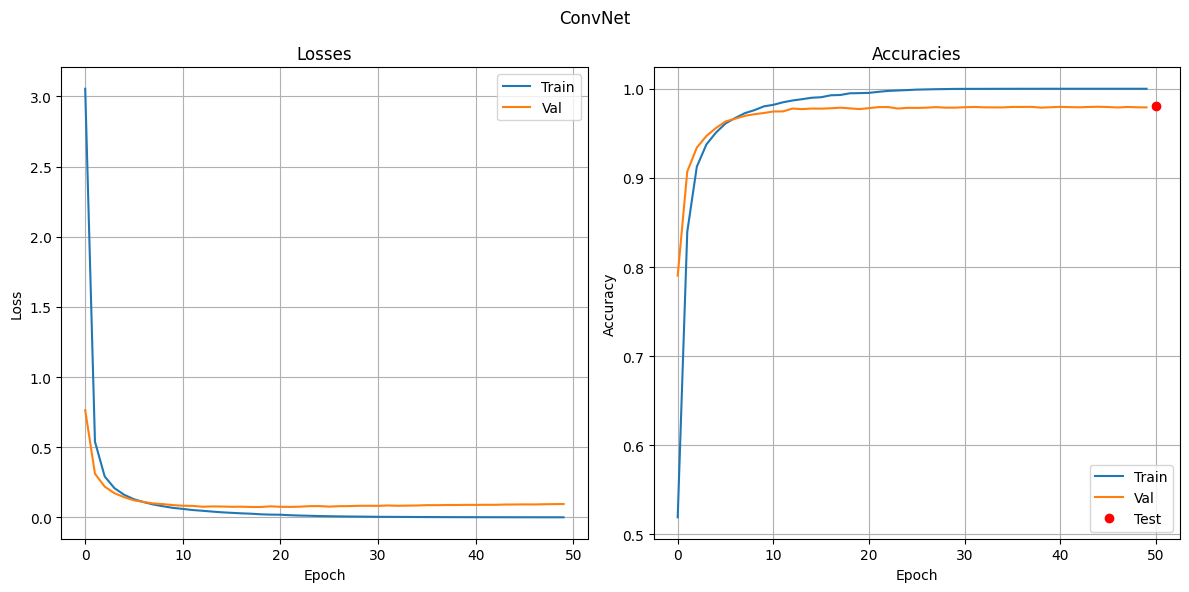

In [ ]:
# Plotting ConvNet Results
plot_results(result)

In [33]:
# Saving the ConvNet Model
save_results(result,device)